# Implementacion de un filtro trapezoidal


Aqui ira la teoria y las ecuaciones de diseño del filtro
.
.
.

refferencias:

- Improvement in Trapezoidal Pulse Shaping Pile-Up in Nuclear Signal Processing
- VHDL Simulation of Trapezoidal Filter for Digital Nuclear Spectroscopy systems


### Conformacion de las señales exponenciales de eventos

Tipicamente los eventos de interaccion nuclear generan una señal del tipo exponencial la cual desea ser representada por el filtro trapezoidal, 

A continuacion se construira la señal a ser evaluada

In [148]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import lfilter, firwin, freqz

- Ecuacion en el continuo
$$X_{amp} = \frac{Q}{Cf}e^{-\frac{t}{\tau}}u(t)$$

- Ecuacion discreta
$$X_{amp} = \frac{Q}{Cf}\frac{1}{1-d z^{-1}}$$

In [149]:
Q = 1  # Carga del detector
Cf = 1 # Capacitancia del detector
tao = 1/5 # constante de tiempo en segundos
Ts = 0.001 # Periodo de muestreo
N = 1/Ts

t = np.arange(0,10,Ts)
delay = 5

In [150]:
def x_amp(A, delay):
    return A*(Q/Cf)*np.exp(-((t-delay)/tao))*np.heaviside(t-delay, 1)

In [151]:
x = x_amp(1,delay)

<function matplotlib.pyplot.show(close=None, block=None)>

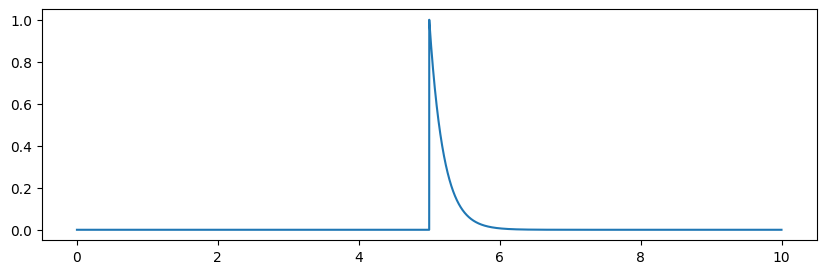

In [152]:
plt.figure(figsize=(10,3))
plt.plot(t,x)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

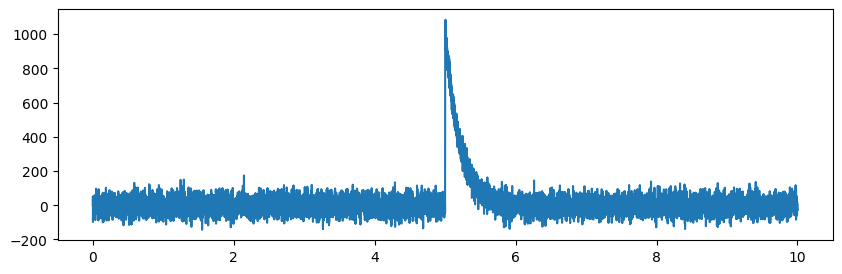

In [153]:
x_noise = (x + 0.04*np.random.randn(len(t))) * 2**10

plt.figure(figsize=(10,3))
plt.plot(t,x_noise)
plt.show

## Implementacion del filtro trapezoidal

In [154]:
K = 500
L = 750
M = 2100

In [155]:
def traps(x):
    y = np.zeros(len(x))
    b = np.zeros(len(x))
    for n in range((K+L),len(x)):
        A = x[n] - x[n-K] - x[n-L] + x[n-K-L]
        b[n] = b[n-1] + A
        C = b[n] + A*M
        
        y[n] = y[n-1] + C

    return y

def trpas_cont (x):
    y = np.zeros(len(x))
    acc = np.zeros([len(x),13])

    d_ = np.floor(np.exp(-Ts/tao) * (2**12))
    a_ = (2**12)

    for n in range(nc+2,len(x)):

        # Particion de la operacion
        acc[n,0]  = np.floor(x[n])
        acc[n,1]  = np.floor(x[n-1] * a_)
        acc[n,2]  = np.floor(- d_ * x[n-2])
        acc[n,3]  = np.floor(- x[n-na-1] * a_)
        acc[n,4]  = np.floor(d_ * x[n-na-2])
        acc[n,5]  = np.floor(- x[n-nb-1] * a_)
        acc[n,6]  = np.floor(d_ * x[n-nb-2])
        acc[n,7]  = np.floor(x[n-nc-1] * a_)
        acc[n,8]  = np.floor(- d_ * x[n-nc-2])
        acc[n,9]  = np.floor(2 * na * y[n-1] * a_)
        acc[n,10] = np.floor(- na * y[n-2] * a_)
        acc[n,11] = np.floor(acc[n,1] + acc[n,2] + acc[n,3] + acc[n,4] + acc[n,5] + acc[n,6] + acc[n,7] + acc[n,8] + acc[n,9] + acc[n,10])
        acc[n,12] = np.round(acc[n,11] / (na * a_))

        y[n] = acc[n,12]

    return y, acc

<function matplotlib.pyplot.show(close=None, block=None)>

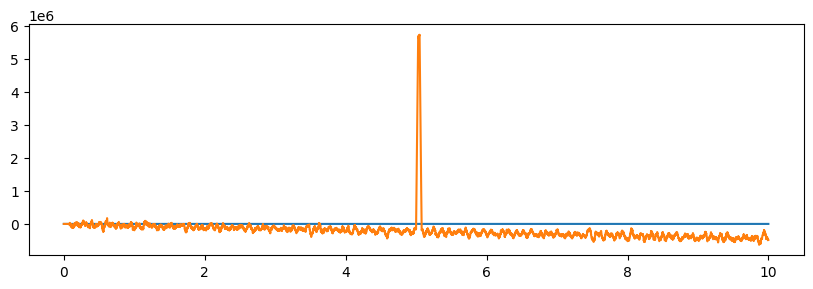

In [178]:
K = 29
L = 50
M = 200

y = traps(x_noise)
plt.figure(figsize=(10,3))
plt.plot(t,x_noise)
plt.plot(t,y)
plt.show

Ejemplo cn multiples pulsos

In [173]:
x = x_amp(0.5,1) + x_amp(0.5,2) + x_amp(0.55,3) + x_amp(0.4,3.2) + x_amp(0.6,5) + x_amp(0.8,5.5)+ x_amp(0.4,6)+ x_amp(0.6,7)+ x_amp(0.5,8)+ x_amp(0.5,9)
x = x + 0.02*np.random.randn(len(t))
    

<function matplotlib.pyplot.show(close=None, block=None)>

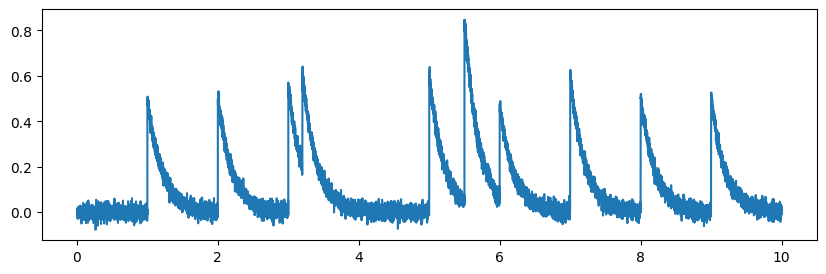

In [174]:
plt.figure(figsize=(10,3))
plt.plot(t,x)
plt.show

In [175]:
data = np.round(x * 2**10).astype(int)
df = pd.DataFrame(data)
df.to_csv('data.csv', index=False)

In [160]:
entrada = np.round(x * 2**12).astype(int)
y_, salida = trpas_cont(entrada)
df = pd.DataFrame(salida)
df.to_csv('dataSalida.csv', index=False, header=["x", "acc0", "acc1", "acc2", "acc3", "acc4", "acc5", "acc6", "acc7", "acc8", "acc9", "cociente", "y"])

NameError: name 'nc' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

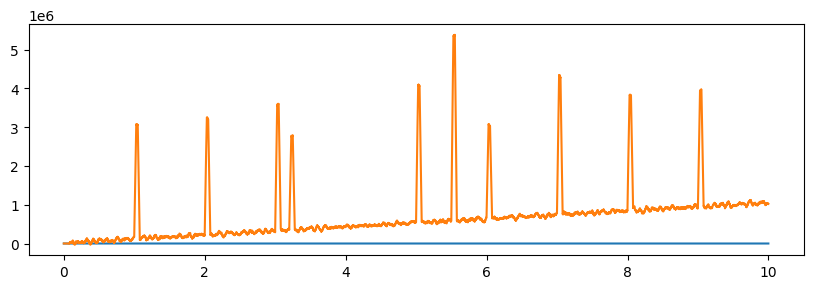

In [180]:
y = traps(data)
plt.figure(figsize=(10,3))
plt.plot(t,x)
plt.plot(t,y)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

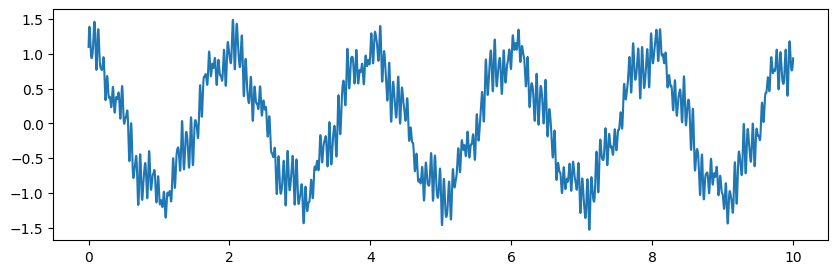

In [ ]:
sig = np.cos(2*np.pi*0.5*t) + 0.2*np.sin(2*np.pi*2.5*t+0.1) + 0.2*np.sin(2*np.pi*15.3*t) + 0.1*np.sin(2*np.pi*16.7*t + 0.1) + 0.1*np.sin(2*np.pi*23.45*t+.8)

plt.figure(figsize=(10,3))
plt.plot(t,sig)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

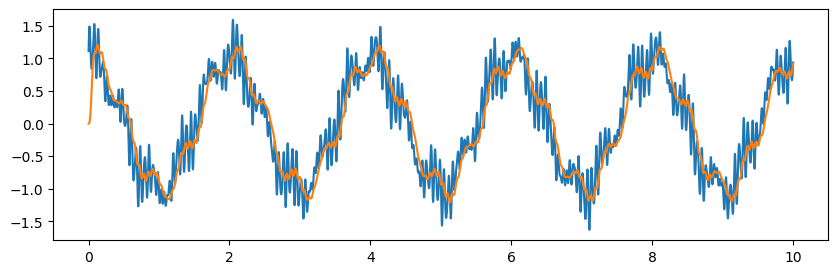

In [ ]:
# Use firwin with a Kaiser window to create a lowpass FIR filter.
#taps = firwin(100, [30/(2*N), 100/(2*N)], window='hann', pass_zero='bandpass')
taps = firwin(100, 10/(2*N), window='hann', pass_zero='lowpass')

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, sig)

plt.figure(figsize=(10,3))
plt.plot(t,sig)
plt.plot(t,filtered_x)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

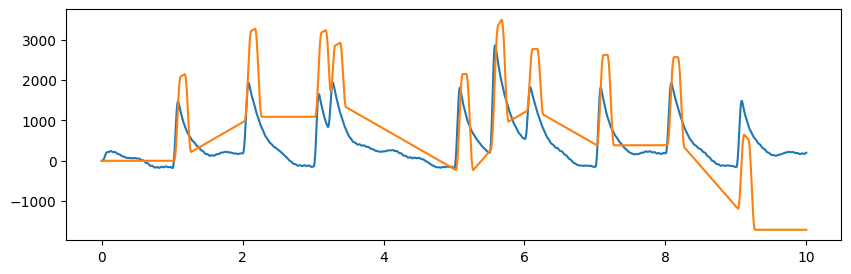

In [ ]:
sig = np.cos(2*np.pi*0.5*t) + 0.2*np.sin(2*np.pi*2.5*t+0.1) + 0.2*np.sin(2*np.pi*15.3*t) + 0.2*np.sin(2*np.pi*16.7*t + 0.1) + 0.1*np.sin(2*np.pi*23.45*t+.8)
data_n = data + np.round(200*sig) #+ np.random.normal(t)
data_n = lfilter(taps, 1.0, data_n)
y_noise, salida_n = trpas_cont(data_n)
#y_noise = traps(data_n)

plt.figure(figsize=(10,3))
plt.plot(t,data_n)
plt.plot(t,y_noise)
plt.show

![image](images/im3.jpeg)
![image](images/im2.jpeg)
![image](images/im1.jpeg)